In [1]:
import sys
if '..' not in sys.path:
    sys.path.append('..')

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import USPS

import matplotlib.pyplot as plt
import numpy as np

from source.models import AE_ReLU, AE_Sigm, AE_Tanh, AE_ReLU_Small
from source.data import get_train_test_dataloaders
from source.eval import reconstruction_loss, classification_loss

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/trinity/home/daria.cherniuk/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def plot_progress(x, z):
    rows = 2
    cols = 16
    x, z = x[:cols], z[:cols]
    fig, ax = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=(cols, rows))
    for i in range(len(x)):
        # ax[i//cols, i%cols].imshow(x[i].cpu().reshape([16, 16]), 'gray')
        # ax[i//cols, i%cols].set_axis_off()
        ax[0, i].imshow(x[i].cpu().reshape([16, 16]), 'gray')
        ax[0, i].set_axis_off()
    for i in range(len(z)):
        # ax[i//cols+2, i%cols].imshow(z[i].detach().cpu().numpy().reshape([16, 16]), 'gray')
        # ax[i//cols+2, i%cols].set_axis_off()
        ax[1, i].imshow(z[i].detach().cpu().numpy().reshape([16, 16]), 'gray')
        ax[1, i].set_axis_off()
    plt.show()

In [4]:
train_loader, _ = get_train_test_dataloaders('..', 'USPS', batch_size=32)

In [5]:
_, test_loader = get_train_test_dataloaders('..', 'USPS', batch_size=10000)

In [6]:
len(test_loader)

1

# Reconstruction

## ReLU, no bias, small

In [7]:
model = AE_ReLU_Small(bias=False,zeros=False).to(device)
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
model

AE_ReLU_Small(
  (encoder): Sequential(
    (0): Linear(in_features=256, out_features=100, bias=False)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=20, bias=False)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=100, bias=False)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=256, bias=False)
  )
)

In [8]:
reconstruction_loss(model, test_loader, loss_function, device=device)

0.16254940629005432

Random-initialized model reconstruction results:


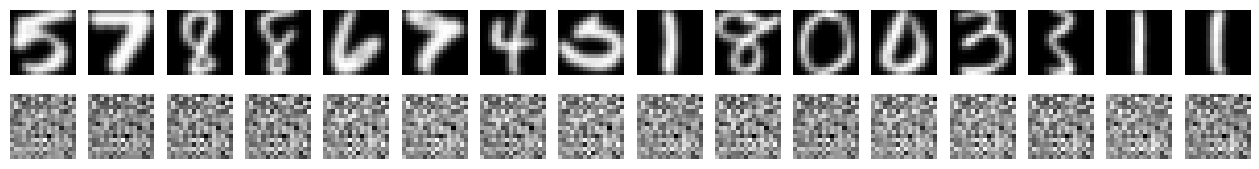

In [9]:
for x, _ in train_loader:
    x = x.to(device)
    with torch.no_grad():
        z = model(x)
    
    print('Random-initialized model reconstruction results:')
    plot_progress(x, z)
    
    break

In [10]:
num_params = 0
for _, param in model.named_parameters():
    num_params += param.numel()
num_params

55200

In [11]:
for x_test, _ in test_loader:
    x_test = x_test.to(device)
    break

epoch : 1/1, loss = 0.008252


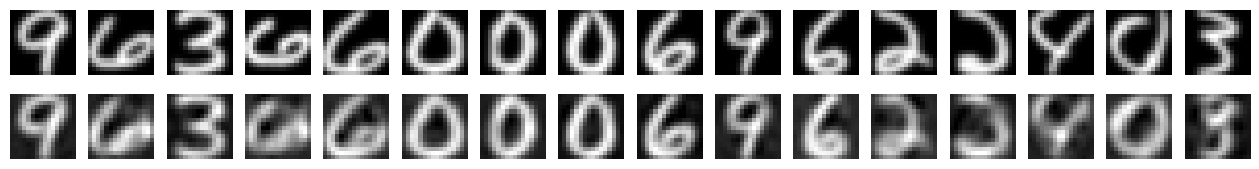

In [19]:
torch.manual_seed(0)

epochs = 1
history = []
history.append(reconstruction_loss(model, test_loader, loss_function, device=device))
model.train()
for epoch in range(epochs):
    loss = 0
    for x, _ in train_loader:
        optimizer.zero_grad()
        
        x = x.to(device)
        z = model(x)
        
        train_loss = loss_function(z, x)
        
        train_loss.backward()
        
        optimizer.step()
        
        loss += train_loss.item()
    
    loss = loss / len(train_loader)
    # history.append(loss)
    
    history.append(reconstruction_loss(model, test_loader, loss_function, device=device))
    
#     if (epoch+1) % 20 == 0:
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, history[-1]))
    if epoch % 5 == 0:
        with torch.no_grad():
            z_test = model(x_test[:16])
        plot_progress(x_test[:16], z_test)
        

In [13]:
reconstruction_loss(model, test_loader, loss_function, device=device)

0.008249187842011452

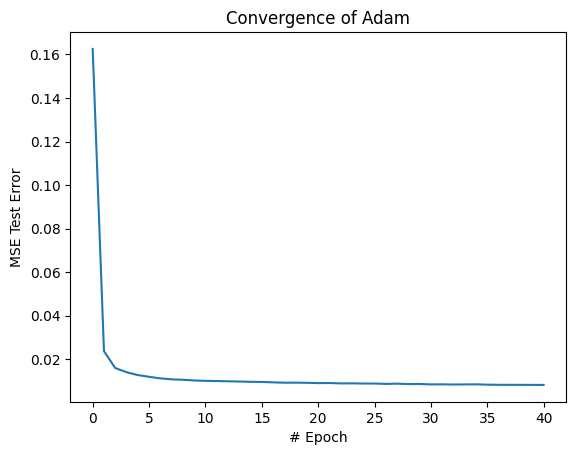

In [17]:
plt.plot(history)
plt.title('Convergence of Adam')
plt.xlabel('# Epoch')
plt.ylabel('MSE Test Error')
plt.show()

In [18]:
history

[0.16254940629005432,
 0.023760829120874405,
 0.016004661098122597,
 0.014084870927035809,
 0.012780304998159409,
 0.011970746330916882,
 0.01126361358910799,
 0.010807299986481667,
 0.010611305013298988,
 0.01030286680907011,
 0.010113365948200226,
 0.010030188597738743,
 0.009916472248733044,
 0.009811135940253735,
 0.00967424176633358,
 0.009626956656575203,
 0.00942172110080719,
 0.009266742505133152,
 0.009282417595386505,
 0.009214953519403934,
 0.009085607714951038,
 0.009124092757701874,
 0.008946041576564312,
 0.008970675989985466,
 0.008886248804628849,
 0.008876477368175983,
 0.00871405191719532,
 0.00881516095250845,
 0.008634080179035664,
 0.008680612780153751,
 0.008490144275128841,
 0.00852028839290142,
 0.008434571325778961,
 0.00848442129790783,
 0.00852308701723814,
 0.008365979418158531,
 0.008301209658384323,
 0.008292445912957191,
 0.008282369934022427,
 0.008252878673374653,
 0.008249187842011452]

## ReLU, no bias

In [33]:
model = AE_ReLU(bias=False).to(device)
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
model

In [34]:
reconstruction_loss(model, test_loader, loss_function, device=device)

0.16215605868233574

Random-initialized model reconstruction results:


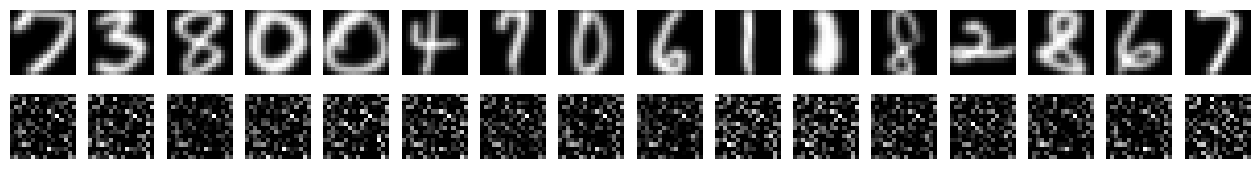

In [35]:
for x, _ in train_loader:
    x = x.to(device)
    with torch.no_grad():
        z = model(x)
    
    print('Random-initialized model reconstruction results:')
    plot_progress(x, z)
    
    break

In [36]:
num_params = 0
for _, param in model.named_parameters():
    num_params += param.numel()
num_params

217600

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.53 µs
epoch : 1/20, loss = 0.053475


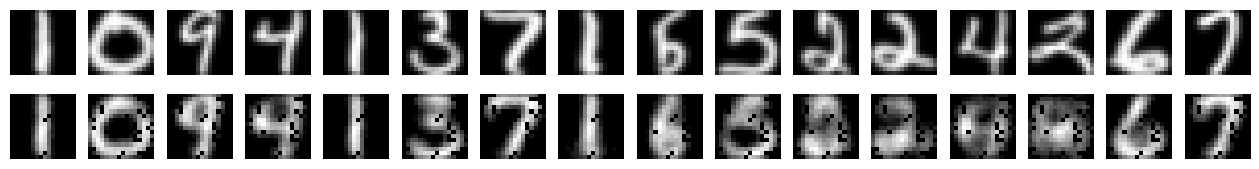

epoch : 2/20, loss = 0.027782
epoch : 3/20, loss = 0.021147
epoch : 4/20, loss = 0.018397
epoch : 5/20, loss = 0.015792
epoch : 6/20, loss = 0.014513


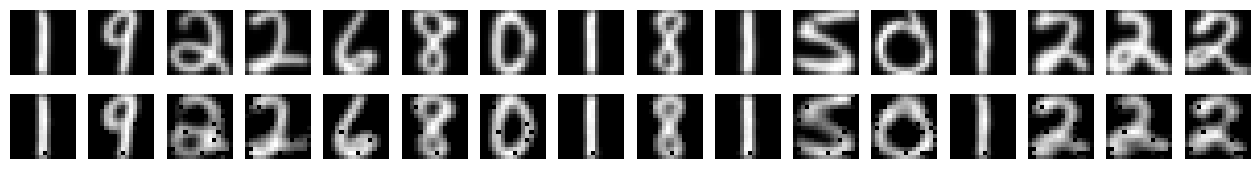

epoch : 7/20, loss = 0.013931
epoch : 8/20, loss = 0.013419
epoch : 9/20, loss = 0.013018
epoch : 10/20, loss = 0.012703
epoch : 11/20, loss = 0.012393


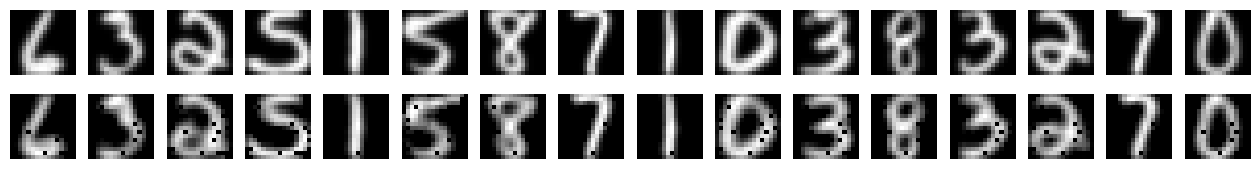

epoch : 12/20, loss = 0.012109
epoch : 13/20, loss = 0.011760
epoch : 14/20, loss = 0.011568
epoch : 15/20, loss = 0.011419
epoch : 16/20, loss = 0.011249


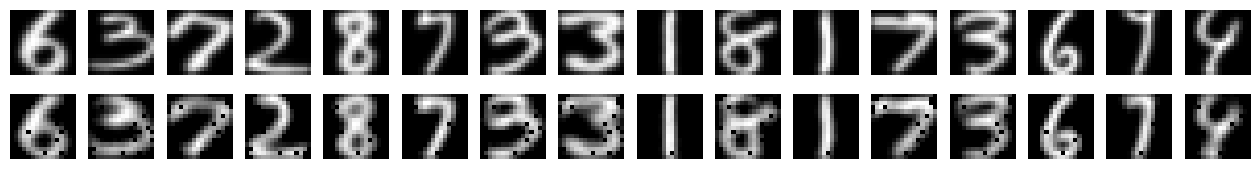

epoch : 17/20, loss = 0.011105
epoch : 18/20, loss = 0.011018
epoch : 19/20, loss = 0.010904
epoch : 20/20, loss = 0.010872


In [37]:
%time
epochs = 20
history = []
history.append(reconstruction_loss(model, test_loader, loss_function, device=device))
model.train()
for epoch in range(epochs):
    loss = 0
    for x, _ in train_loader:
        optimizer.zero_grad()
        
        x = x.to(device)
        z = model(x)
        
        train_loss = loss_function(z, x)
        
        train_loss.backward()
        
        optimizer.step()
        
        loss += train_loss.item()
    
    loss = loss / len(train_loader)
    history.append(loss)
    
#     if (epoch+1) % 20 == 0:
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))
    if epoch % 5 == 0:
        plot_progress(x, z)

In [40]:
reconstruction_loss(model, test_loader, loss_function, device=device)

0.012170757869228957

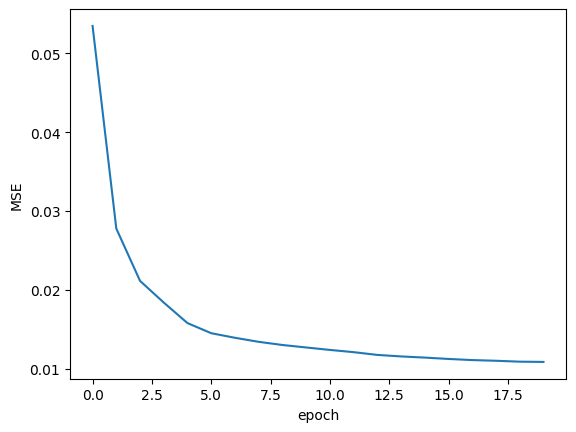

In [41]:
plt.plot(history)
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.show()

In [23]:
# torch.save(model.state_dict(), f'../checkpoints/adam_usps_{epochs}ep.sd')
# np.save(f'../checkpoints/adam_usps_{epochs}ep.loss', history)

## Sigm, no bias

In [5]:
model = AE_Sigm(bias=False).to(device)
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
model

In [6]:
eval_loss(model, test_loader, loss_function, device=device)

0.24091094211926536

Random-initialized model reconstruction results:


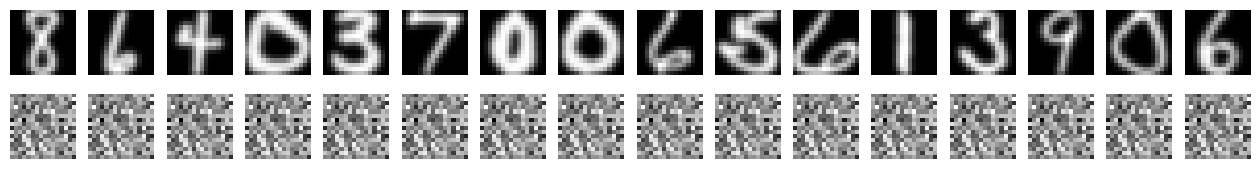

In [7]:
for x, _ in train_loader:
    x = x.to(device)
    with torch.no_grad():
        z = model(x)
    
    print('Random-initialized model reconstruction results:')
    plot_progress(x, z)
    
    break

In [8]:
num_params = 0
for _, param in model.named_parameters():
    num_params += param.numel()
num_params

217600

CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 4.29 µs
epoch : 1/20, loss = 0.063454


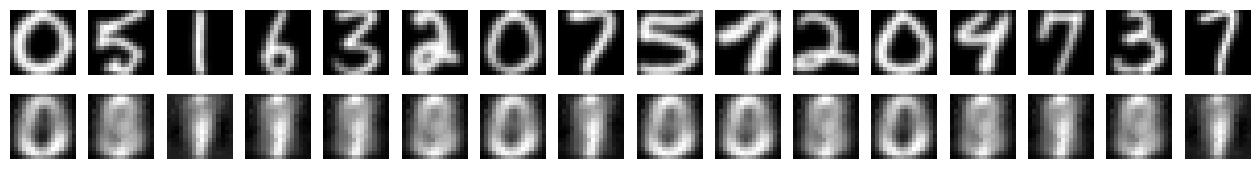

epoch : 2/20, loss = 0.049559
epoch : 3/20, loss = 0.047292
epoch : 4/20, loss = 0.044417
epoch : 5/20, loss = 0.040102
epoch : 6/20, loss = 0.038623


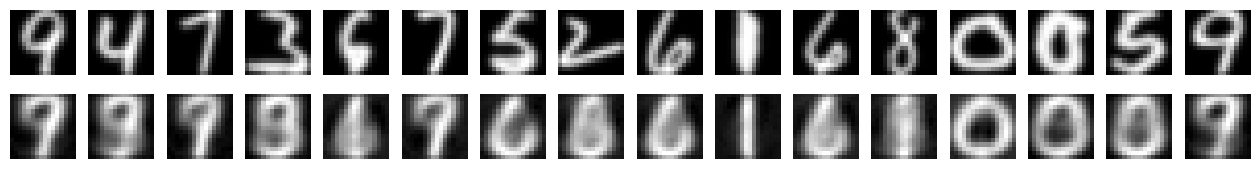

epoch : 7/20, loss = 0.034633
epoch : 8/20, loss = 0.031584
epoch : 9/20, loss = 0.029939
epoch : 10/20, loss = 0.027223
epoch : 11/20, loss = 0.025949


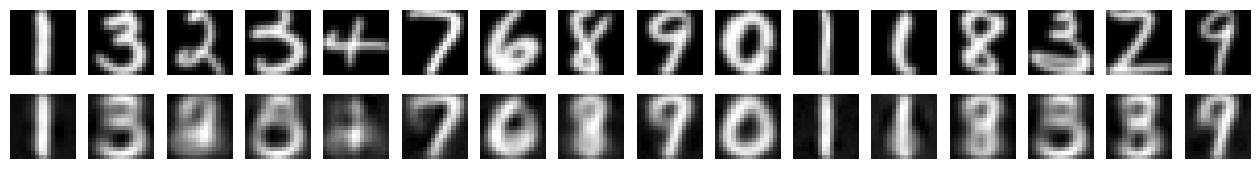

epoch : 12/20, loss = 0.025366
epoch : 13/20, loss = 0.024708
epoch : 14/20, loss = 0.023761
epoch : 15/20, loss = 0.022822
epoch : 16/20, loss = 0.022100


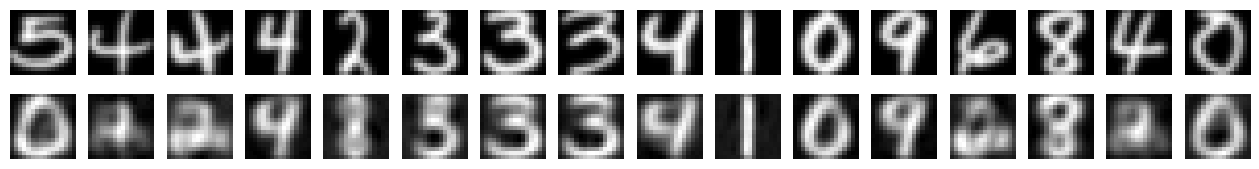

epoch : 17/20, loss = 0.021499
epoch : 18/20, loss = 0.021041
epoch : 19/20, loss = 0.020586
epoch : 20/20, loss = 0.020194


In [9]:
%time
epochs = 20
history = []
model.train()
for epoch in range(epochs):
    loss = 0
    for x, _ in train_loader:
        optimizer.zero_grad()
        
        x = x.to(device)
        z = model(x)
        
        train_loss = loss_function(z, x)
        
        train_loss.backward()
        
        optimizer.step()
        
        loss += train_loss.item()
    
    loss = loss / len(train_loader)
    history.append(loss)
    
#     if (epoch+1) % 20 == 0:
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))
    if epoch % 5 == 0:
        plot_progress(x, z)

In [10]:
eval_loss(model, test_loader, loss_function, device=device)

0.022334716489745512

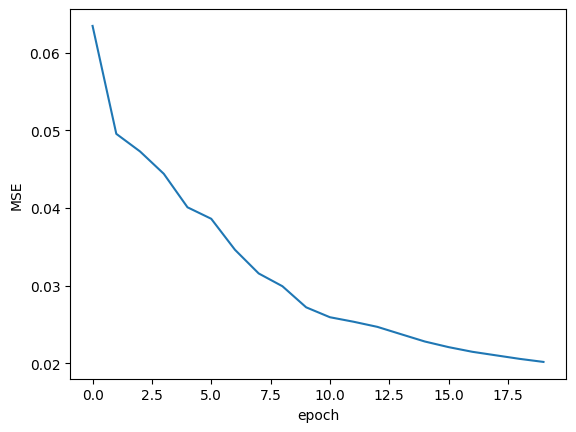

In [11]:
plt.plot(history)
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.show()

## Tanh, no bias

In [5]:
model = AE_Tanh(bias=False).to(device)
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
model

AE_Tanh(
  (encoder): Sequential(
    (0): Linear(in_features=256, out_features=300, bias=False)
    (1): Tanh()
    (2): Linear(in_features=300, out_features=100, bias=False)
    (3): Tanh()
    (4): Linear(in_features=100, out_features=20, bias=False)
    (5): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=100, bias=False)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=300, bias=False)
    (3): Tanh()
    (4): Linear(in_features=300, out_features=256, bias=False)
  )
)

In [6]:
eval_loss(model, test_loader, loss_function, device=device)

0.16340959888129009

Random-initialized model reconstruction results:


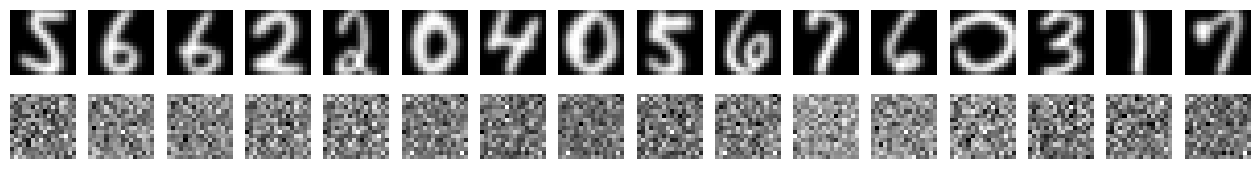

In [7]:
for x, _ in train_loader:
    x = x.to(device)
    with torch.no_grad():
        z = model(x)
    
    print('Random-initialized model reconstruction results:')
    plot_progress(x, z)
    
    break

In [8]:
num_params = 0
for _, param in model.named_parameters():
    num_params += param.numel()
num_params

217600

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs
epoch : 1/20, loss = 0.028717


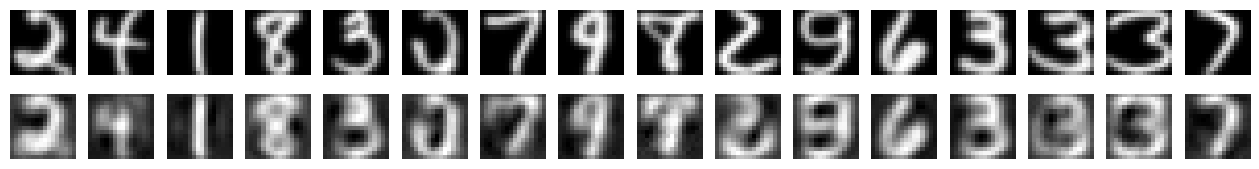

epoch : 2/20, loss = 0.010739
epoch : 3/20, loss = 0.008660
epoch : 4/20, loss = 0.008201
epoch : 5/20, loss = 0.008023
epoch : 6/20, loss = 0.008011


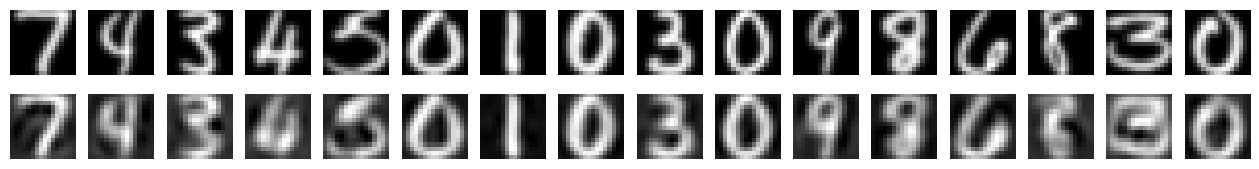

epoch : 7/20, loss = 0.008024
epoch : 8/20, loss = 0.008026
epoch : 9/20, loss = 0.007931
epoch : 10/20, loss = 0.007879
epoch : 11/20, loss = 0.007901


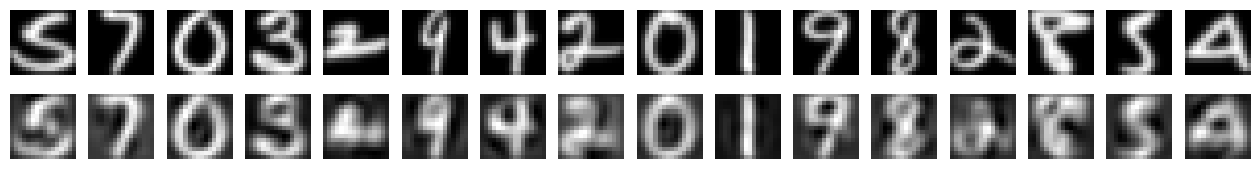

epoch : 12/20, loss = 0.008051
epoch : 13/20, loss = 0.007865
epoch : 14/20, loss = 0.007919
epoch : 15/20, loss = 0.007990
epoch : 16/20, loss = 0.007923


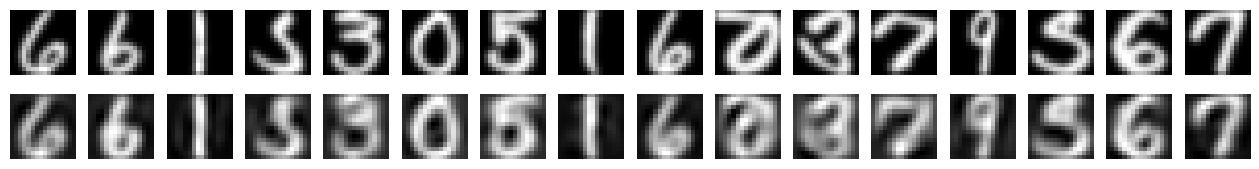

epoch : 17/20, loss = 0.007915
epoch : 18/20, loss = 0.007946
epoch : 19/20, loss = 0.007996
epoch : 20/20, loss = 0.007993


In [9]:
%time
epochs = 20
history = []
model.train()
for epoch in range(epochs):
    loss = 0
    for x, _ in train_loader:
        optimizer.zero_grad()
        
        x = x.to(device)
        z = model(x)
        
        train_loss = loss_function(z, x)
        
        train_loss.backward()
        
        optimizer.step()
        
        loss += train_loss.item()
    
    loss = loss / len(train_loader)
    history.append(loss)
    
#     if (epoch+1) % 20 == 0:
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))
    if epoch % 5 == 0:
        plot_progress(x, z)